In [75]:
import nltk
import random
import numpy as np
import pandas as pd

In [76]:
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [77]:
# get the book list
bookList = gutenberg.fileids()
print(bookList)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [78]:
books = np.array(bookList[3])
books = np.append(books, bookList[13])
books = np.append(books, bookList[6])
books = np.append(books, bookList[8])
books = np.append(books, bookList[15])

In [79]:
def sampling(number_samples, sample_size, book_name):
    labeled_records = []
    book = gutenberg.raw(book_name)
    # print(book)
    # tokenize the material of the book
    raw_words = nltk.word_tokenize(book)
    # print(raw_words)
    # Prepare 200 documents for each book
    headers = random.sample(range(0, len(raw_words)), number_samples)

    for header in headers:
        segment = raw_words[header:(header + sample_size + 1)]
        labeled_records.append((segment, book_name))
    return labeled_records

In [80]:
from string import punctuation
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
def data_cleaning(sample_words):
    # customize the punctuation list by adding extra string
    extra_string = "'-- ``'' "
    update_punctuation = punctuation + extra_string
    # customize the stopwords list by adding extra stopwords
    sw = stopwords.words('english')
    extra_stopwords = "n't", "'s", "ar't", "'d", "'ll", "i'll"
    sw.extend(extra_stopwords)
    # Remove punctuation
    remove_punct_words = [w for w in sample_words if w not in update_punctuation]
    # Change all letters to lowercase
    lowercase_words = [w.lower() for w in remove_punct_words]
    # Strip "_" at the beginning or end of a word
    strip_words = [w.strip('_') for w in lowercase_words]
    # Remember digits/numbers (keeps only words)
    remove_number_words = [w for w in strip_words if w.isalpha()]
    # Remove stop words
    final_words = [w for w in remove_number_words if w not in sw]
    return final_words

In [82]:
if __name__ == "__main__":
    try_number_samples = 200
    try_sample_size = 150
    final_list = []
    for book_name in books:
        # print (book_name)
        labeled_list = sampling(try_number_samples, try_sample_size, book_name)
        cleaned_labeled_list = []

        for samples in labeled_list:
            book_name = samples[1]

            cleaned_seg = data_cleaning(samples[0])
            cleaned_labeled_seg = (cleaned_seg, book_name)
            # print(cleaned_labeled_seg)
            cleaned_labeled_list.append(cleaned_labeled_seg)
        # print(cleaned_labeled_list)
        final_list = final_list + cleaned_labeled_list
    # shuffle the list
#     shuffle(final_list)
    #print(final_list)

    docs = []
    tags = []

    # word lemmatization
    lem = WordNetLemmatizer()
    for labeled_doc in final_list:
        docs.append(lem.lemmatize(' '.join(labeled_doc[0])))
        tags.append(labeled_doc[1])
#     print(docs)
    # import data to dictionary
    dic = {'Text': docs, 'File_name': tags}
    # apply pandas data frame
    df = pd.DataFrame(dic)
#     print(df)
    # df.columns = ['Text', 'File_name']
    df['book_id'] = df['File_name'].factorize()[0]
    book_id_df = df[['File_name', 'book_id']].drop_duplicates().sort_values('book_id')
    book_to_id = dict(book_id_df.values)
    id_to_book = dict(book_id_df[['book_id', 'File_name']].values)
    df=pd.read_csv('final_output.csv')
    # feature engineering： TF-IDF
#     tfidf = TfidfVectorizer(sublinear_tf=True, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(df['Text'])

    from sklearn.decomposition import LatentDirichletAllocation
    # Apply LDA to the document-term matrix
    lda_model = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=42)
    features = lda_model.fit_transform(features)

#     print(features)

In [83]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features)

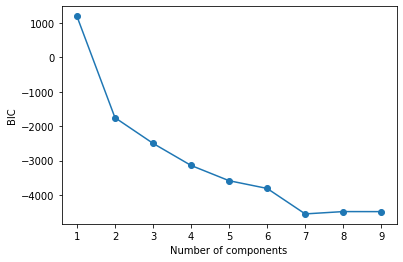

Best number of components: 7


In [84]:
from sklearn.mixture import GaussianMixture
n_components_range = range(1, 10)
bic = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(Y_sklearn)
    bic.append(gmm.bic(Y_sklearn))

# Plot BIC for different number of components
import matplotlib.pyplot as plt
plt.plot(n_components_range, bic, 'o-')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.show()

# Find the best number of components
best_n_components = n_components_range[np.argmin(bic)]
print('Best number of components:', best_n_components)

In [85]:
#EM clustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features)
gmm = GaussianMixture(n_components=7).fit(Y_sklearn)
labels = gmm.predict(Y_sklearn)

In [86]:
def statistics(predict):
    stat = []
    new_id = []
    for i in range(0, 1000, 200):
        ratio = []
        most_possible_id = 0
        max_count = 0
        for j in range(7):
            # count = predict[i:i + 200].count(j)
            counter = collections.Counter(predict[i:i + 200])
            count = counter[j]
            ratio.append(count / 200)
            if count > max_count:
                max_count = count
                most_possible_id = j
        stat.append(ratio)
        new_id.append(most_possible_id)
    return stat, new_id

In [87]:
# obtain cluster id from predict result
import collections
em_predict = gmm.predict(Y_sklearn)
stat, new_id = statistics(em_predict)
predict_df = pd.DataFrame(stat, index = books, columns=['0', '1', '2', '3', '4', '5', '6'])
print(predict_df)
print(new_id)
# create new book id
ids = []
for k in new_id:
    arr = np.ones(200)
    ids.append(arr * k)
book_cluster_ids = np.array(ids,dtype='int8').flatten()
# assign new book id to the df
df['cluster_id'] = book_cluster_ids
df.cluster_id

                            0      1      2      3      4      5      6
bible-kjv.txt            0.05  0.790  0.000  0.005  0.145  0.000  0.010
milton-paradise.txt      0.60  0.310  0.005  0.000  0.020  0.000  0.065
burgess-busterbrown.txt  0.00  0.000  0.465  0.200  0.000  0.215  0.120
chesterton-ball.txt      0.45  0.325  0.010  0.000  0.055  0.000  0.160
shakespeare-hamlet.txt   0.80  0.035  0.025  0.000  0.075  0.000  0.065
[1, 0, 2, 0, 0]


0      1
1      1
2      1
3      1
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: cluster_id, Length: 1000, dtype: int8

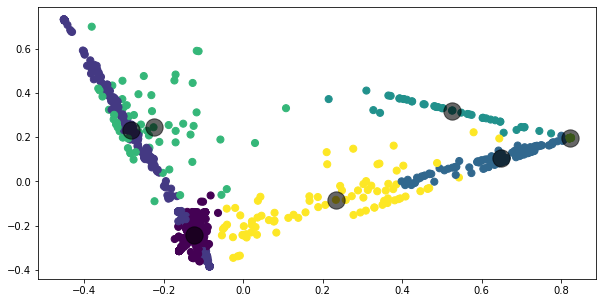

In [88]:
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
centers = np.zeros((7,2))
for i in range(7):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]
plt.figure(figsize = (10,5))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=labels ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
plt.show()

In [89]:
#evaluation of EM
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(df.cluster_id,labels))

0.4534179405826362


In [90]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
print(homogeneity_score(df.cluster_id, gmm.predict(Y_sklearn)))
silhouette_score(features, labels=gmm.predict(Y_sklearn))

0.5998756547557965


0.004799602168664992